## Generate motion path figures.

Generate figures for motion paths.

In [1]:
from __future__ import print_function

import pygplates
import matplotlib.pyplot as plt
import numpy as np
import os.path
from scipy.signal import medfilt

import matplotlib as mpl
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "arial"
mpl.rcParams['text.usetex'] == True


#######################################################
# Define Input files
#######################################################

print(pygplates.__version__)

#model_dir = 'Global_Model_WD_Internal_Release_2019_v3'
model_dir = 'Global_1000-0_Model_2017'

if model_dir.startswith('Global_Model_WD_Internal_Release'):
    # Define the time snapshots at which to sample the motion paths
    min_time = 0.
    max_time = 410.
    
    rotation_base_filenames = [
        'Alps_Mesh_Rotations_2019_v2',
        'Andes_Flat_Slabs_Rotations_2019_v2',
        'Andes_Rotations_2019_v2',
        'Australia_Antarctica_Mesh_Rotations_2019_v2',
        'Australia_North_Zealandia_Rotations_2019_v2',
        'Eurasia_Arabia_Mesh_Rotations_2019_v2',
        'Global_250-0Ma_Rotations_2019_v2',
        'Global_410-250Ma_Rotations_2019_v2',
        'North_America_Flat_Slabs_Rotations_2019_v2',
        'North_America_Mesh_Rotations_2019_v2',
        'North_China_Mesh_Rotations_2019_v2',
        'Southeast_Asia_Rotations_2019_v2',
        'South_Atlantic_Rotations_2019_v2',
        'South_China_DeformingModel_xianzhi',
    ]
    
    # Motion path models to plot.
    motion_path_infos = [
    ]
elif model_dir == 'Global_1000-0_Model_2017':
    # Define the time snapshots at which to sample the motion paths
    min_time = 0.
    max_time = 1000.
    
    rotation_base_filenames = ['1000_0_rotfile_T12_APWP_mean50']

    # Motion path models to plot.
    motion_path_infos = [
        (None, 'red', 'Not Optimized'),
        ('svn1628_run10', 'blue', 'svn1628 run10 (TM=1;1, NR=1, PV=1 | TM[-30,30], NR[0.08,0.2], PV[0,60])'),
        ('svn1628_run12', 'green', 'svn1628 run12 (TM=1;1, NR=1, PV=1 | TM[-30,30], NR[0.08,0.2], PV[0,60])'),
        ('svn1628_run13', 'darkorange', 'svn1628 run13 (TM=1;1, NR=1, PV=1 | TM[-30,30], NR[0.08,0.2], PV[0,60])'),
    ]
else:
    # Define the time snapshots at which to sample the motion paths
    min_time = 0.
    max_time = 410.
    
    rotation_base_filenames = []
    
    # Motion path models to plot.
    motion_path_infos = []

time_step = 5.0
    
input_dir = '../data/{0}'.format(model_dir)
output_dir = './{0}'.format(model_dir)

original_rotation_filenames = [os.path.join(input_dir, rotation_base_filename + '.rot')
        for rotation_base_filename in rotation_base_filenames]

# Typically the achor plate id should be 0
anchor_plate_id = 0

2.2.0.28


In [2]:
import pygplates


# Specify a (lat/lon) seed point on the equator and in the middle of Africa.
africa_seed_point_present_day = pygplates.PointOnSphere(0.0, 27.5)

# A list of times to sample the motion path.
times = np.arange(min_time, max_time+1, time_step)

africa_motion_path_times_list = []
africa_motion_path_lats_list = []
africa_motion_path_lons_list = []

for motion_path_info in motion_path_infos:
    model_name, _, _ = motion_path_info
    
    if model_name is None:
        # Un-optimised rotation model.
        rotation_model = pygplates.RotationModel(original_rotation_filenames)
    else:
        # Optimised rotation model.
        optimised_rotation_filenames = [
                os.path.join(input_dir, 'optimisation', rotation_base_filename + '_{0}.rot'.format(model_name))
                    for rotation_base_filename in rotation_base_filenames]
        rotation_model = pygplates.RotationModel(optimised_rotation_filenames)

    africa_seed_point = africa_seed_point_present_day
    
    # If the present day Africa rotation is non-zero then reverse rotate the seed point such
    # that when it's reconstructed to present day it will be at the position specified above.
    africa_present_day_rotation = rotation_model.get_rotation(0.0, 701)
    if not africa_present_day_rotation.represents_identity_rotation():
        africa_seed_point = africa_present_day_rotation.get_inverse() * africa_seed_point

    # Create a motion path feature.
    africa_motion_path_feature = pygplates.Feature.create_motion_path(
            africa_seed_point,
            times,
            valid_time=(max(times), min(times)),
            relative_plate=0,
            reconstruction_plate_id=701)

    # Reconstruct the motion path feature to present day.
    africa_reconstructed_motion_paths = []
    pygplates.reconstruct(africa_motion_path_feature, rotation_model, africa_reconstructed_motion_paths, 0.0,
        reconstruct_type=pygplates.ReconstructType.motion_path)

    africa_motion_path_times = []
    africa_motion_path_lats = []
    africa_motion_path_lons = []
    
    # We could iterate over all reconstructed motion paths.
    # But there's only one (since only one seed point).
    reconstructed_motion_path = africa_reconstructed_motion_paths[0]
    motion_path_times = reconstructed_motion_path.get_feature().get_times()

    # Iterate over the points in the motion path.
    for point_index, point in enumerate(reconstructed_motion_path.get_motion_path()):

        lat, lon = point.to_lat_lon()

        # The first point in the path is the oldest and the last point is the youngest.
        # So we need to start at the last time and work our way backwards.
        time = motion_path_times[-1-point_index]

        africa_motion_path_times.append(time)
        africa_motion_path_lats.append(lat)
        africa_motion_path_lons.append(lon)
            
    africa_motion_path_times_list.append(africa_motion_path_times)
    africa_motion_path_lats_list.append(africa_motion_path_lats)
    africa_motion_path_lons_list.append(africa_motion_path_lons)


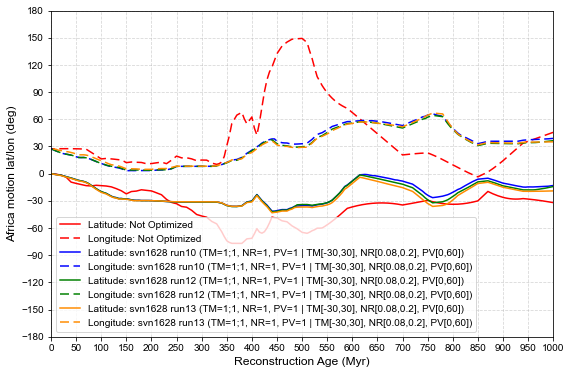

In [4]:
def plot_africa_motion_paths(medfilt_kernel_sizes):
    
    for medfilt_kernel_size in medfilt_kernel_sizes:
        
        fig = plt.figure(figsize=(9,6))

        for motion_path_index in range(len(motion_path_infos)):
            africa_motion_path_times = africa_motion_path_times_list[motion_path_index]
            africa_motion_path_lats = africa_motion_path_lats_list[motion_path_index]
            africa_motion_path_lons = africa_motion_path_lons_list[motion_path_index]
            
            _, color, label = motion_path_infos[motion_path_index]
            
            # Latitude.
            plt.plot(
                africa_motion_path_times,
                medfilt(africa_motion_path_lats, medfilt_kernel_size),
                color,
                label='Latitude: {0}'.format(label))
            # Longitude.
            plt.plot(
                africa_motion_path_times,
                medfilt(africa_motion_path_lons, medfilt_kernel_size),
                color,
                dashes=(6,3), # Same colour but with dashes.
                label='Longitude: {0}'.format(label))

        plt.xlim([min(africa_motion_path_times), max(africa_motion_path_times)])
        plt.ylim([-180, 180])
        plt.xticks(np.arange(min_time, max_time+1, 50))
        plt.yticks(np.arange(-180, 181, 30))
        plt.ylabel('Africa motion lat/lon (deg)', fontsize=12)
        plt.xlabel('Reconstruction Age (Myr)', fontsize=12)
        plt.grid(linestyle='--',alpha=0.5)

        plt.legend(fontsize=10)

        plt.savefig(
            os.path.join(model_dir, 'africa_motion_%dMy.pdf' % medfilt_kernel_size),
            format='pdf',
            dpi=600)

        plt.show()


#medfilt_kernel_sizes = [1, 5, 11]
medfilt_kernel_sizes = [1]

plot_africa_motion_paths(medfilt_kernel_sizes)